<a href="https://colab.research.google.com/github/RiyaH2020/Explainability_in_Vision_transformers/blob/main/CNN_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN explainability

-- Manami Das MDS202423

-- Riya Shyam Huddar MDS202431

### **Why Explain CNNs?**

* CNNs make decisions based on hierarchical features
* Understanding *which image regions influence predictions* improves trust, transparency, and debugging


### **How CNNs See Images**

* Convolution layers produce **spatial feature maps**
* Each activation at position **(i, j)** corresponds to a specific region of the input image
* Deeper layers capture higher-level concepts (edges → textures → object parts)





In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms, utils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [ ]:
import json
import urllib.request

## Preprocessing + Image Loader

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(path):
    img = Image.open(path).convert("RGB")
    tensor = preprocess(img).unsqueeze(0).to(device)
    return img, tensor



### **`preprocess = transforms.Compose([...])`**

This creates a pipeline that:

1. **Resizes** the image to 224×224
2. Converts it to a **PyTorch tensor**
3. **Normalizes** it using ImageNet mean and std (what ResNet expect)

---

### **`load_image(path)`**

* Loads the image in RGB
* Applies preprocessing
* Adds a **batch dimension** (`unsqueeze(0)`)
* Moves it to GPU/CPU (`to(device)`)
* Returns both the original image and the processed tensor




## Load Pretrained CNN (ResNet-50)

In [ ]:
model = models.resnet50(pretrained=True).to(device).eval()
model


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 


* Loads a **ResNet-50** model with **pretrained ImageNet weights**
* Moves it to **GPU/CPU** (`device`)
* Sets it to **evaluation mode** (`eval()`) so dropout/batchnorm behave correctly for inference



## Classification

In [ ]:
with torch.no_grad():
    logits = model(x)
    probabilities = torch.softmax(logits, dim=1)[0]

In [ ]:
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_labels = urllib.request.urlopen(url).read().decode("utf-8").splitlines()


### **`with torch.no_grad():`**

Runs the model **without tracking gradients**
→ faster and uses less memory (good for inference).

---

### **`logits = model(x)`**

Feeds the preprocessed image `x` into the model
→ produces raw class scores (**logits**).

---

### **`probabilities = torch.softmax(logits, dim=1)[0]`**

Converts logits into **probabilities** across the 1000 ImageNet classes.
`[0]` selects the first (and only) image in the batch.

---

### **Load ImageNet labels**


Downloads the list of **ImageNet class names** so you can map
`predicted_class_index → human-readable label` (e.g., "golden retriever").



In [ ]:
top5 = torch.topk(probabilities, 5)
for idx, score in zip(top5.indices, top5.values):
    print(imagenet_labels[idx], float(score))

airliner 0.8590304255485535
wing 0.10869486629962921
warplane 0.021028921008110046
space shuttle 0.006849721074104309
aircraft carrier 0.0012029818026348948


So the prediction is of **airplane**


The code `top5 = torch.topk(probabilities, 5)` extracts the five classes with the highest predicted probabilities for the input image. It returns both the class indices and their corresponding confidence scores. The loop then pairs each class index with its score and prints the human-readable ImageNet label using `imagenet_labels[idx]` along with the probability value. In summary, this block prints the model’s **top-5 most likely classes** for the image and how confident it is about each prediction.


## Feature Maps

In [ ]:
def get_feature_maps(model, layer_name, x):
    activations = {}

    # locate target layer
    submod = model
    for name in layer_name.split('.'):
        submod = getattr(submod, name) if not name.isdigit() else submod[int(name)]

    def hook_fn(module, inp, out):
        activations["value"] = out.detach().cpu()

    handle = submod.register_forward_hook(hook_fn)
    _ = model(x)   # forward pass
    handle.remove()

    return activations["value"]  # shape: 1 x C x H x W



The function `get_feature_maps` extracts the **feature maps** produced by a specific layer in the CNN during a forward pass. It first locates the target layer by navigating through the model’s nested modules using the layer name (e.g., `"layer4.2.conv3"`). A forward hook is then attached to that layer, so when the model processes the input `x`, the hook captures the layer’s output activations and stores them in a dictionary. After one forward pass, the hook is removed, and the function returns the saved feature maps as a tensor of shape **(1, C, H, W)**, representing the batch size, number of channels, height, and width of the activation map. This is commonly used to visualize what the CNN has learned or for methods like Grad-CAM.


In [ ]:
def visualize_feature_maps(feat, ncols=8):
    fmap = feat.squeeze(0)   # C x H x W
    C = fmap.shape[0]

    maps_norm = []
    for c in range(C):
        v = fmap[c]
        mn, mx = v.min(), v.max()
        maps_norm.append(((v - mn) / (mx - mn + 1e-5)).unsqueeze(0))

    # Change from torch.cat to torch.stack to correctly add a batch dimension for make_grid
    grid = utils.make_grid(torch.stack(maps_norm), nrow=ncols, padding=1)

    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0), cmap='viridis')
    plt.title("Feature Maps")
    plt.axis('off')
    plt.show()



The function `visualize_feature_maps` displays the **feature maps** from a CNN layer. It first removes the batch dimension to get a tensor of shape **C × H × W**, then normalizes each channel so it can be visualized as an image. All normalized maps are stacked and arranged into a grid using `make_grid`. Finally, the grid is plotted with Matplotlib, allowing you to see what each channel (filter) of the CNN is detecting.




## Grad-CAM

---

### **Grad-CAM for CNNs**

* **Grad-CAM (Gradient-weighted Class Activation Mapping)** highlights image regions most responsible for a prediction
* Uses:

  * **Activations** from a convolution layer
  * **Gradients** of the target class score
* Produces a **class-specific heatmap** over the image

---

### **Key Idea**

> **Important channels = large gradients**
>
> **Important spatial locations = bright activations**
>
> Grad-CAM combines both to show *where the model looked*.

---

### **Why Grad-CAM Works for CNNs**

* CNNs maintain spatial structure → heatmaps map cleanly to image regions
* Channels represent meaningful feature detectors
* Local receptive fields preserve positional information

---

## How It Explains CNNs

 1. Convolutional Feature Maps
CNN layers produce spatial feature maps (H×W).
Each channel detects patterns like edges, textures, shapes.

 2. Compute Gradients for the Target Class
Backpropagate the score of the chosen class.
Gradients show which channels were important for that class.

 3. Compute Channel Importance (αₖ)
Gradients are averaged over spatial dimensions →
importance weight for each channel.

 4. Weighted Combination of Feature Maps
Multiply each activation map by its importance weight:
CAM = ReLU( Σₖ αₖ × Activationₖ )

 5. Generate a Heatmap Overlay
Upsample the CAM to input image size →
highlight regions the CNN focused on.

**This class grabs feature maps + gradients from a CNN layer and combines them to generate a class-specific heatmap that shows where the network looked when making its prediction.**

In [ ]:
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model.eval()
        self.target_layer = self._get_layer(layer_name)

        self.gradients = None
        self.activations = None

        self.fh = self.target_layer.register_forward_hook(self.forward_hook)
        self.bh = self.target_layer.register_backward_hook(self.backward_hook)

    def _get_layer(self, layer_name):
        submod = self.model
        for name in layer_name.split('.'):
            submod = getattr(submod, name) if not name.isdigit() else submod[int(name)]
        return submod

    def forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def generate(self, x, class_idx=None):
        self.model.zero_grad()
        logits = self.model(x)

        if class_idx is None:
            class_idx = logits.argmax(1).item()

        score = logits[0, class_idx]
        score.backward()

        grads = torch.mean(self.gradients, dim=(2, 3), keepdim=True)  # Avg pool gradients
        cam = torch.sum(self.activations * grads, dim=1)[0]           # Weighted activation

        cam = F.relu(cam)
        cam = cam.cpu().numpy()

        cam -= cam.min()
        cam /= cam.max() + 1e-8
        return cam

    def close(self):
        self.fh.remove()
        self.bh.remove()


The GradCAM class explains CNN predictions by capturing what a chosen convolution layer “sees” and how important each part of that layer is for the predicted class. It uses **hooks**, which are small functions attached to a layer to record information during the forward or backward pass. A **forward hook** saves the layer’s **feature maps** (the spatial patterns the CNN detects), while a **backward hook** saves the **gradients of the chosen class**, which show how sensitive the class score is to each feature. Grad-CAM averages these gradients to get the importance of each feature-map channel, multiplies them with the feature maps, and produces a heatmap showing which image regions were most influential for the model’s decision.


In [ ]:
def overlay_heatmap(image, heatmap, alpha=0.5):
    img_np = np.array(image)
    h, w = img_np.shape[:2]

    heatmap_resized = cv2.resize(heatmap, (w, h))
    heatmap_color = cv2.applyColorMap((heatmap_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img_np, 1-alpha, heatmap_color, alpha, 0)
    return overlay


### **Explanation of `overlay_heatmap` Function (Short)**

The `overlay_heatmap` function blends a model’s heatmap (e.g., Grad-CAM) on top of the original image to create a visual explanation. It first converts the input image to a NumPy array and resizes the heatmap to match the image’s width and height. The heatmap is then converted into a **jet color map** (blue → red) for better visibility. Finally, the function blends the colored heatmap with the original image using a transparency factor (`alpha`), producing an output where important regions appear highlighted while the original image remains visible.




Layer 1

In [ ]:

layer2 = "layer1"
feat2 = get_feature_maps(model, layer2, x)

feat2.shape


torch.Size([1, 256, 56, 56])

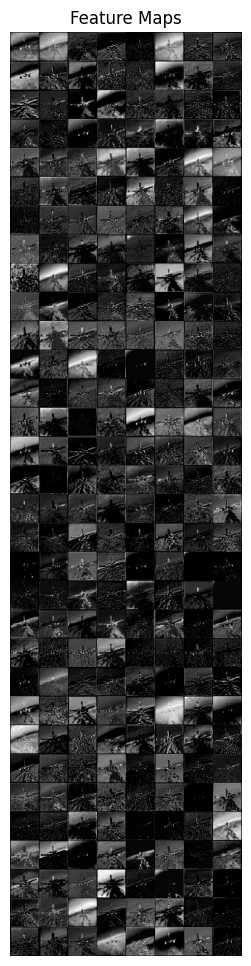

In [ ]:
visualize_feature_maps(feat2)


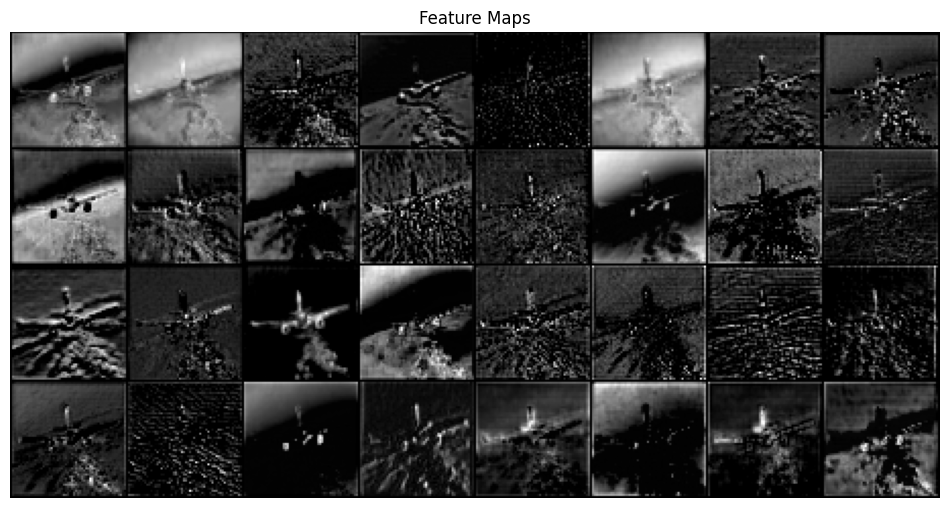

In [ ]:
subset2 = feat2[:, :32, :, :]   # first 32 channels
visualize_feature_maps(subset2, ncols=8)


## **Interpretation of Layer-1 Feature Maps (Shallow CNN Layer)**

These feature maps come from the **first convolutional layer**, which captures the *lowest-level* patterns in the image. Unlike deeper layers that detect shapes or object parts, layer-1 learns extremely **basic visual primitives**.

### **What they show:**

### **1. Edge detectors (horizontal, vertical, diagonal)**

Most maps highlight bright lines or boundaries — the model is detecting **edges** all across the image.

### **2. Color and brightness contrasts**

Several maps respond to **light vs. dark** transitions, or **color contrasts**, capturing very primitive texture information.

### **3. Simple texture patterns**

Some maps show grainy or repetitive patterns, indicating the model is learning simple **texture features** like smooth areas vs. rough areas.

### **4. High spatial detail**

Layer-1 retains most of the original image’s resolution, so the feature maps look **similar** to the image but filtered in different ways.



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


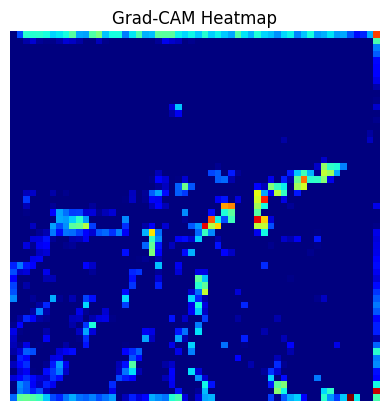

In [ ]:
gc2 = GradCAM(model, "layer1")
heatmap2 = gc2.generate(x)
gc2.close()

plt.imshow(heatmap2, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()



## **Interpretation of the Grad-CAM Heatmap**

This Grad-CAM heatmap highlights the regions of the image that the CNN considered most important for its prediction. The **red and yellow areas** represent the highest contribution to the predicted class, while **green and light blue** indicate moderate importance, and **dark blue** shows regions with little or no influence.

In this heatmap, the strongest activations appear along a **linear diagonal structure** in the middle-right portion of the image. This means the model is focusing on that prominent shape or edge when making its classification. The scattered small bright spots suggest the network is also responding to other noticeable edges and local textures across the image, but with much lower importance.

**Overall**, the model’s decision is primarily driven by the bright yellow/red patterns, which correspond to the **most discriminative object parts** in the image, while the rest of the regions contribute minimally.



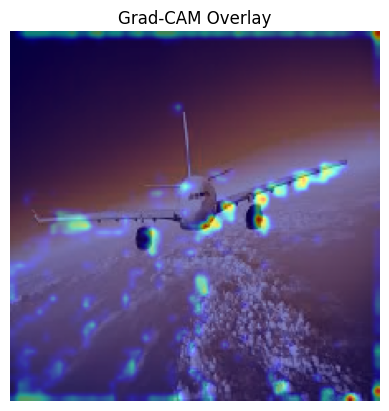

In [ ]:
overlay_img2 = overlay_heatmap(orig, heatmap2)

plt.imshow(overlay_img2[:, :, ::-1])
plt.title("Grad-CAM Overlay")
plt.axis('off')
plt.show()


### Layer 2

In [ ]:

layer3 = "layer2"
feat3 = get_feature_maps(model, layer3, x)

feat3.shape


torch.Size([1, 512, 28, 28])

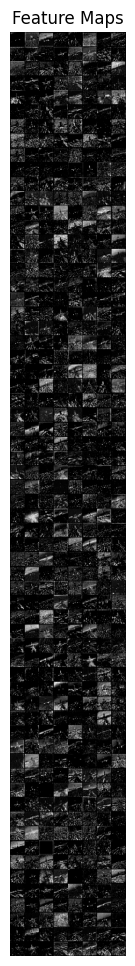

In [ ]:
visualize_feature_maps(feat3)


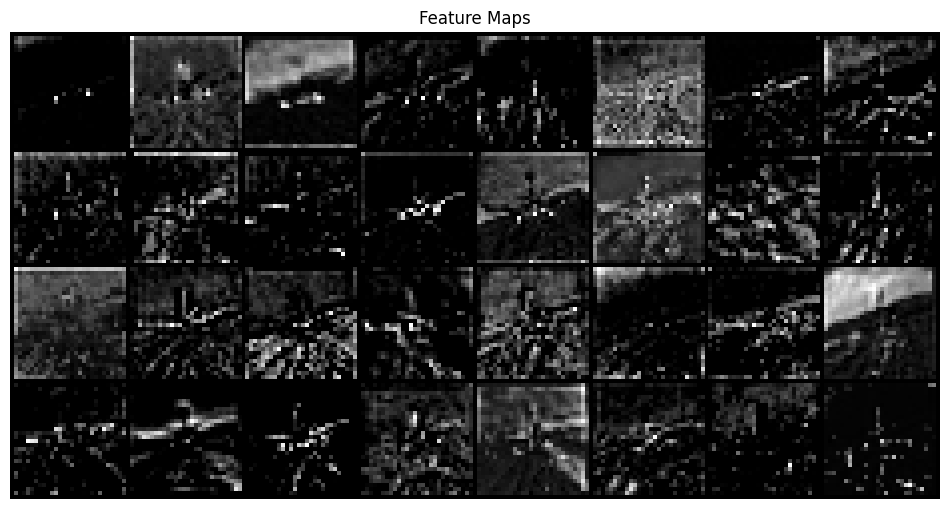

In [ ]:
subset3 = feat3[:, :32, :, :]   # first 32 channels
visualize_feature_maps(subset3, ncols=8)


Here is a **clear, concise interpretation** of the layer’s feature maps you provided:

---

## **Interpretation of These Feature Maps**

These feature maps come from **2nd layer**, where the network transitions from detecting simple edges to recognizing more meaningful patterns. Unlike the shallow layer (layer1), which detects basic edges and colors, these maps show **more structured and object-aware activations**.

### **What they indicate:**

### **1. Mid-level textures and patterns**

Many maps highlight repetitive textures, curves, and structural patterns—indicating the model is learning **texture groups**, **contours**, and **regional shapes**.

### **2. Partial object components**

Some maps clearly emphasize **parts of the object**, such as outlines, surfaces, shadows, and mid-level shapes. These are building blocks used by deeper layers for full object recognition.

### **3. Increased abstraction**

Compared to layer1, these maps look less like the original image and more like **abstract feature detectors**, meaning the network is focusing on more meaningful semantic cues rather than raw pixels.

### **4. Spatial selectivity**

Bright regions indicate where certain features activate strongly—these may correspond to specific body parts, surfaces, or high-contrast regions.




/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


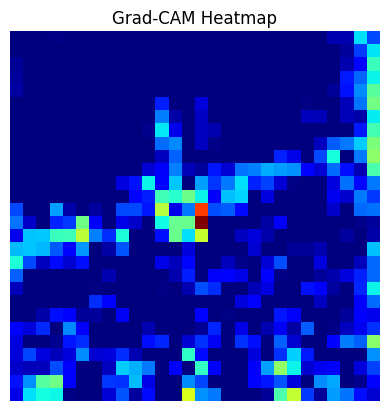

In [ ]:
gc3 = GradCAM(model, "layer2")
heatmap3 = gc3.generate(x)
gc2.close()

plt.imshow(heatmap3, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()


## **Interpretation of the Grad-CAM Heatmap**

The concentration of warm colors around a specific central structure suggests that the model is focusing on a distinctive feature—likely a key object part or a strong edge—while ignoring large portions of the background. This pattern shows that the CNN has learned to detect the most discriminative region rather than treating the entire image uniformly.



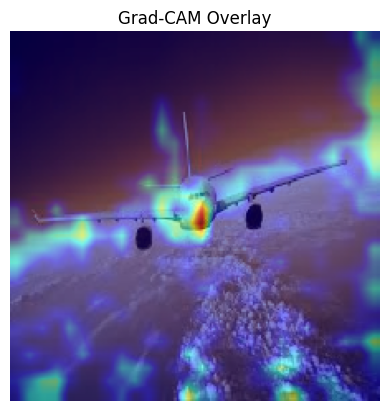

In [ ]:
overlay_img3 = overlay_heatmap(orig, heatmap3)

plt.imshow(overlay_img3[:, :, ::-1])
plt.title("Grad-CAM Overlay")
plt.axis('off')
plt.show()


### Layer 3

In [ ]:

layer4 = "layer3"
feat4 = get_feature_maps(model, layer4, x)

feat4.shape


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


torch.Size([1, 1024, 14, 14])

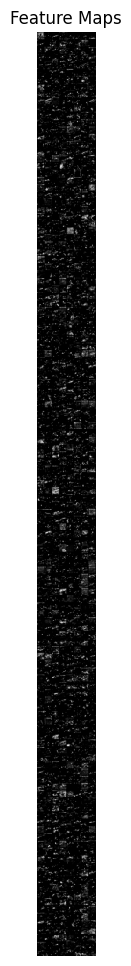

In [ ]:
visualize_feature_maps(feat4)


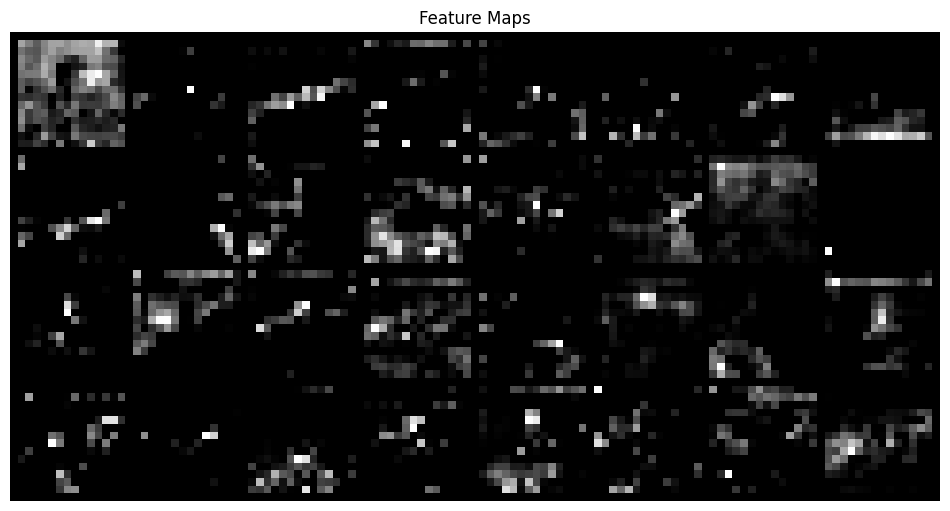

In [ ]:
subset4 = feat4[:, :32, :, :]   # first 32 channels
visualize_feature_maps(subset4, ncols=8)


## **Interpretation of Layer-3 Feature Maps**

These feature maps come from a **deeper, higher-level convolution block** (layer3), where the network begins to assemble **more abstract semantic features** from the mid-level patterns detected earlier.

### **What they show:**

### **1. Highly abstract and sparse activations**

Most maps contain scattered bright spots, indicating the layer is focusing only on **specific, meaningful regions**, not the entire image. The patterns are more selective than in layer2.

### **2. Detection of complex shapes and object parts**

Unlike early layers that capture edges or simple textures, layer3 responds to **curves, corners, junctions, surface textures, and partial object structures**. These features are building blocks for deeper object recognition.

### **3. Reduced resemblance to the raw image**

The maps no longer visually resemble the original scene; instead, they represent **conceptual features** extracted by the CNN. This abstraction is a sign that the model is learning semantic information.

### **4. Increased diversity across filters**

Each channel highlights different patterns—some detect large smooth regions, others detect repetitive textures, others identify strong structural cues. This diversity helps the network encode rich representations.

---



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


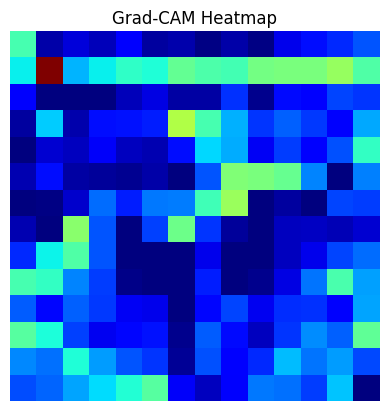

In [ ]:
gc4 = GradCAM(model, "layer3")
heatmap4 = gc4.generate(x)
gc4.close()

plt.imshow(heatmap4, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()




# ⭐ **Interpretation of the Grad-CAM Heatmap (Layer 3)**

This Grad-CAM heatmap shows which regions of the image activated **deeper, more abstract filters** in layer 3 most strongly for the predicted class. Unlike shallow layers that react to edges, this layer highlights **semantic structures**.

### **Key observations:**

### **1. Strong activation in the upper-left region**

The red patch in the upper-left corner indicates the **most influential** part of the image for this class at this layer. This suggests a **distinctive structure or texture** in that region that the model relies on.

### **2. Moderate activation spread across mid-image**

Green and cyan regions show areas contributing to the prediction but with **lower importance**. These likely correspond to **partial textures or shapes** detected by mid-level filters.

### **3. Large low-importance areas**

Dark blue regions represent parts of the image the model considers **irrelevant** for this layer’s decisions, meaning the model is becoming more selective.

### **4. Higher abstraction**

The heatmap appears more **fragmented and pattern-based**, consistent with layer-3 filters that focus on **complex textures**, **junctions**, and **object parts** rather than whole objects.



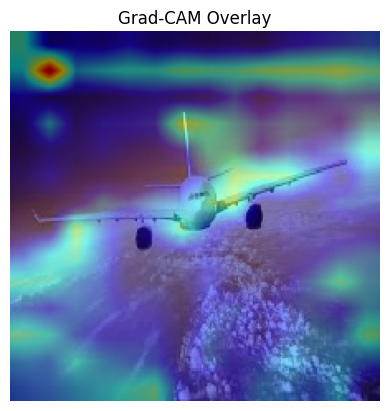

In [ ]:
overlay_img4 = overlay_heatmap(orig, heatmap4,alpha=0.5)

plt.imshow(overlay_img4[:, :, ::-1])
plt.title("Grad-CAM Overlay")
plt.axis('off')
plt.show()


### Layer 4

In [ ]:
img_path = "plane2.png"
orig, x = load_image(img_path)

layer = "layer4"
feat = get_feature_maps(model, layer, x)

feat.shape


torch.Size([1, 2048, 7, 7])

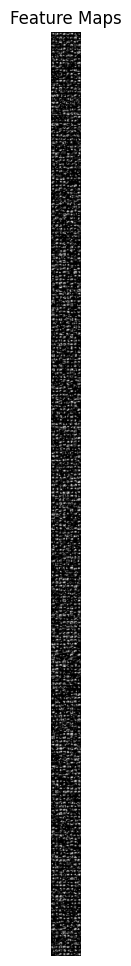

In [ ]:
visualize_feature_maps(feat)


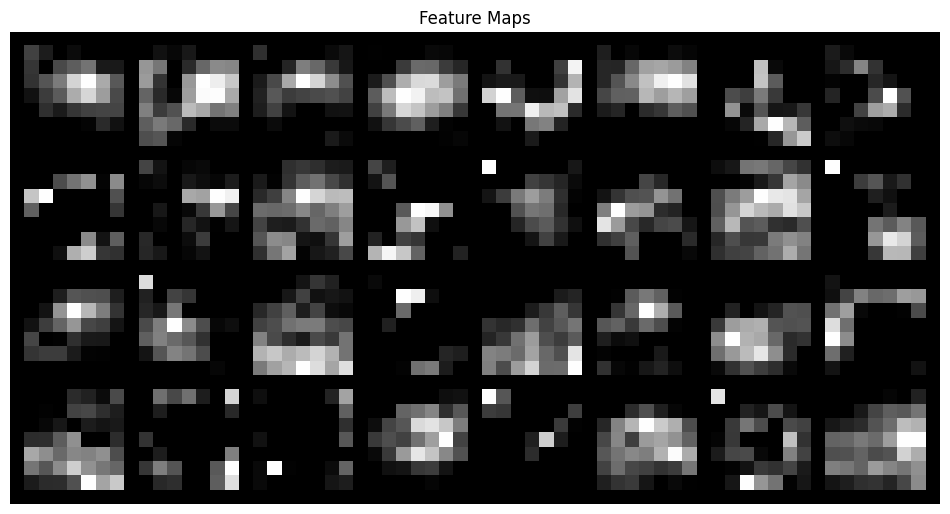

In [ ]:
subset = feat[:, :32, :, :]   # first 32 channels
visualize_feature_maps(subset, ncols=8)


## **Interpretation of the Feature Maps (Layer 4 of ResNet)**

This image shows a **grid of many small grayscale patches**, each one representing a **feature map channel** produced by **ResNet layer4** (the deepest convolution block). Each small patch is one filter’s response over the spatial grid.

Because this is a **deep layer**, the maps no longer capture simple edges or textures. Instead, they show:

### **1. High-level abstract patterns**

Many maps have faint, sparse activations—this means the layer is detecting **complex shapes**, **object parts**, or **semantic concepts**, not raw pixels.

### **2. Strong activations in specific spatial regions**

Bright spots in some maps indicate locations in the image where certain high-level features were strongly detected (e.g., contours, texture boundaries, object regions).

### **3. Diversity across channels**

Each channel looks very different—this shows that different filters specialize in recognizing **different types of features**.

### **4. Very compressed spatial information**

Layer4 has small spatial maps (e.g., 7×7), so the network is focusing on **coarse outlines and object-level cues**, not fine details.



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


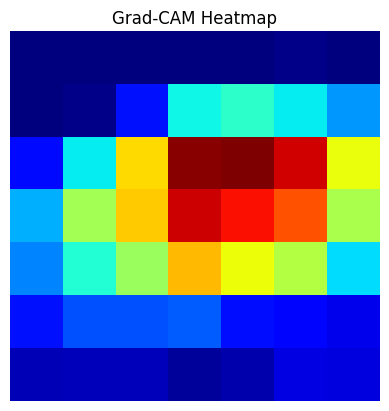

In [ ]:
gc = GradCAM(model, "layer4")
heatmap = gc.generate(x)
gc.close()

plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()




This heatmap comes from **layer 4**, the deepest convolution block, where the CNN focuses on **high-level semantic concepts** and complete object structures rather than textures or edges. The strong, concentrated red region in the center indicates the **most discriminative area of the image** for the final classification.

### **Key observations:**

### **1. Very strong central activation**

The bright red patch shows where the model believes the **core identity of the object** lies. Deep layers respond to **object-level cues**, so this region likely corresponds to a highly characteristic part of the object (e.g., body, head, main structure).

### **2. Smooth, coarse attention**

Layer-4 activations are spatially coarse (low resolution), so the heatmap is **broad and smooth**, highlighting general object regions rather than fine details.

### **3. Peripheral regions are unimportant**

Dark blue around the edges shows the model **ignores the background**, relying almost entirely on the central object region to make its decision.

### **4. Semantic selectivity**

Unlike shallower layers that activate for textures or edges, layer 4 highlights **where the object itself is**, not how it looks at a low level. This implies the model has formed a **high-level understanding** of the object.

---




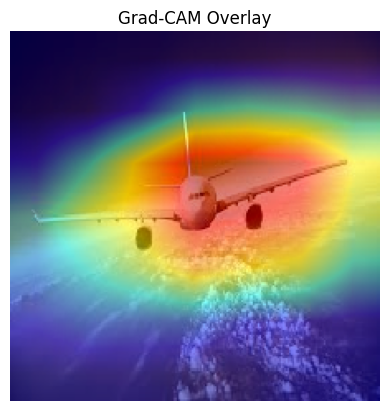

In [ ]:

overlay_img = overlay_heatmap(orig, heatmap)

plt.imshow(overlay_img[:, :, ::-1])
plt.title("Grad-CAM Overlay")
plt.axis('off')
plt.show()


---
---